In [1]:
import pandas as pd
import numpy as np

### Data

In [2]:
data1 = pd.read_csv('../../Data/Jeju/201901-202003.csv')
data1 = data1.fillna('')
data2 = pd.read_csv('../../Data/Jeju/202004.csv')
data2 = data2.fillna('')

In [3]:
data = pd.concat([data1, data2])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048114 entries, 0 to 1350321
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ GB


#### 결측 처리

In [5]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 18 사업체총조사

In [6]:
all_jobs_df = pd.read_csv('data/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [7]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [8]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [9]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 거래횟수와 이용고객과의 관계 (2019)

In [10]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [11]:
trade_num_2019 = cust_differ(data)

#### 거래횟수와 이용고객과의 관계 (2020)

In [12]:
def cust_differ_2020(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2020만 사용
    melt_plus = melt_plus[melt_plus.year == 2020]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2020만 사용
    melt_minus = melt_minus[melt_minus.year == 2020]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [13]:
trade_num_2020 = cust_differ_2020(data)

In [14]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [15]:
trade_num.loyal = trade_num.loyal.fillna(-999)
trade_num.refund = trade_num.refund.fillna(999)

In [16]:
trade_num

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,999.0
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,999.0
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,999.0
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,-999.0,1,999.0
...,...,...,...,...,...,...
2575,충북,휴양콘도 운영업,202004.0,62.0,4,999.0
2576,대전,여행사업,202001.0,-999.0,1,999.0
2577,대전,여행사업,202002.0,-999.0,2,999.0
2578,대전,여행사업,202003.0,-999.0,3,999.0


#### 추가변수 결합

In [17]:
data.shape

(26048114, 13)

In [18]:
local_percent_df

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,REG_YYMM,LP
0,강원,강릉시,건강보조식품 소매업,201901,0.138432
1,강원,강릉시,골프장 운영업,201901,0.148825
2,강원,강릉시,과실 및 채소 소매업,201901,1.468549
3,강원,강릉시,관광 민예품 및 선물용품 소매업,201901,0.022661
4,강원,강릉시,그외 기타 스포츠시설 운영업,201901,0.003255
...,...,...,...,...,...
124523,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,202004,1.362619
124524,충북,충주시,한식 음식점업,202004,18.402971
124525,충북,충주시,호텔업,202004,0.059226
124526,충북,충주시,화장품 및 방향제 소매업,202004,0.368080


In [19]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [20]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [21]:
grouped.head(5)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0


In [22]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [23]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [24]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630138,2020-04-01,16,202,40,16,1,1,1,77000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630139,2020-04-01,16,202,40,16,2,1,2,92000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630140,2020-04-01,16,202,40,16,3,2,3,193000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630141,2020-04-01,16,202,40,16,4,1,4,86000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0


In [25]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [26]:
train_df = df_num[df_num['REG_YYMM'] <= '2020-01-01']
validation_df = df_num[(df_num['REG_YYMM'] > '2020-01-01') & (df_num['REG_YYMM'] <'2020-04-01')]

In [27]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num[df_num['REG_YYMM'] >= '2020']
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [28]:
temp.month = 7
temp = pd.concat([df_num[df_num['REG_YYMM'] == '2020-04-01'], temp])

In [29]:
temp.REG_YYMM[temp['REG_YYMM'] != '2020-04-01'] = dt.datetime(2020,7,1)

C:\Users\lonj7\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
temp

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
5328210,2020-04-01,0,4,0,0,3,1,3,779600.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0
5328211,2020-04-01,0,4,0,0,3,2,3,2427700.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0
5328212,2020-04-01,0,4,0,0,4,1,4,2184600.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0
5328213,2020-04-01,0,4,0,0,4,2,4,3653100.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0
5328214,2020-04-01,0,4,0,0,5,1,5,2765500.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430404,2020-07-01,16,202,40,16,3,2,3,NaN,11.0,492.0,0.033359,0.056592,585.000000,7,329.666667,2020.0
430405,2020-07-01,16,202,40,16,4,1,4,NaN,11.0,492.0,0.026140,0.045117,455.500000,7,497.000000,2020.0
430406,2020-07-01,16,202,40,16,4,2,4,NaN,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0
430407,2020-07-01,16,202,40,16,5,1,5,NaN,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0


#### gdp, trade

In [31]:
# world_gdp = pd.read_csv("data/world_gdp.csv")
trade_amount = pd.read_csv("data/Trade in goods and services forecast.csv")

# world_gdp.REG_YYMM = pd.to_datetime(world_gdp.REG_YYMM)
trade_amount.REG_YYMM = pd.to_datetime(trade_amount.REG_YYMM)

In [32]:
trade_amount = trade_amount.drop(['Couyntry'], axis=1)
trade_amount.Value = np.log1p(trade_amount.Value)

In [33]:
# add to temp

# temp = pd.merge(temp, world_gdp, on=['REG_YYMM'], how='left')
temp = pd.merge(temp, trade_amount, on=['REG_YYMM'], how='left')

In [34]:
temp

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year,Value
0,2020-04-01,0,4,0,0,3,1,3,779600.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0,27.091453
1,2020-04-01,0,4,0,0,3,2,3,2427700.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0,27.091453
2,2020-04-01,0,4,0,0,4,1,4,2184600.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0,27.091453
3,2020-04-01,0,4,0,0,4,2,4,3653100.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0,27.091453
4,2020-04-01,0,4,0,0,5,1,5,2765500.0,263.0,399.0,0.142831,0.347117,98.000000,4,-18.000000,2020.0,27.091453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732337,2020-07-01,16,202,40,16,3,2,3,NaN,11.0,492.0,0.033359,0.056592,585.000000,7,329.666667,2020.0,27.120195
732338,2020-07-01,16,202,40,16,4,1,4,NaN,11.0,492.0,0.026140,0.045117,455.500000,7,497.000000,2020.0,27.120195
732339,2020-07-01,16,202,40,16,4,2,4,NaN,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0,27.120195
732340,2020-07-01,16,202,40,16,5,1,5,NaN,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0,27.120195


In [35]:
train_df

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737053,2020-01-01,16,202,40,16,3,1,4,108000,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020
4737054,2020-01-01,16,202,40,16,3,2,3,219000,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020
4737055,2020-01-01,16,202,40,16,4,1,4,1176300,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020
4737056,2020-01-01,16,202,40,16,4,2,4,432600,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020


In [36]:
# add to train_df

# train_df = pd.merge(train_df, world_gdp, on=['REG_YYMM'], how='left')
train_df = pd.merge(train_df, trade_amount, on=['REG_YYMM'], how='left')

In [37]:
train_df

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year,Value
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019,27.113507
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019,27.113507
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019,27.113507
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019,27.113507
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019,27.113507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737053,2020-01-01,16,202,40,16,3,1,4,108000,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020,27.121861
4737054,2020-01-01,16,202,40,16,3,2,3,219000,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020,27.121861
4737055,2020-01-01,16,202,40,16,4,1,4,1176300,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020,27.121861
4737056,2020-01-01,16,202,40,16,4,2,4,432600,11.0,492.0,0.078091,0.117169,1367.0,1,-9.0,2020,27.121861


In [38]:
# add to validation

# validation_df = pd.merge(validation_df, world_gdp, on=['REG_YYMM'], how='left')
validation_df = pd.merge(validation_df, trade_amount, on=['REG_YYMM'], how='left')

In [39]:
validation_df

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year,Value
0,2020-02-01,0,4,0,0,2,1,2,335000,263.0,399.0,0.079882,0.205675,50.0,2,-27.0,2020,27.121861
1,2020-02-01,0,4,0,0,3,1,3,149000,263.0,399.0,0.079882,0.205675,50.0,2,-27.0,2020,27.121861
2,2020-02-01,0,4,0,0,3,2,3,502200,263.0,399.0,0.079882,0.205675,50.0,2,-27.0,2020,27.121861
3,2020-02-01,0,4,0,0,4,1,4,4973500,263.0,399.0,0.079882,0.205675,50.0,2,-27.0,2020,27.121861
4,2020-02-01,0,4,0,0,4,2,4,2489494,263.0,399.0,0.079882,0.205675,50.0,2,-27.0,2020,27.121861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591147,2020-03-01,16,202,40,16,2,1,2,43300,11.0,492.0,0.004484,0.010694,67.0,3,999.0,2020,27.121861
591148,2020-03-01,16,202,40,16,3,1,3,35000,11.0,492.0,0.004484,0.010694,67.0,3,999.0,2020,27.121861
591149,2020-03-01,16,202,40,16,4,1,4,188000,11.0,492.0,0.004484,0.010694,67.0,3,999.0,2020,27.121861
591150,2020-03-01,16,202,40,16,4,2,4,99000,11.0,492.0,0.004484,0.010694,67.0,3,999.0,2020,27.121861


In [40]:
temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

### Light GBM

In [41]:
import lightgbm as lgb

In [42]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year,Value
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019,27.113507


In [43]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [44]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [45]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [46]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.45,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [47]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=5000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),)

[1]	training's rmse: 2.02225	valid_1's rmse: 2.00837
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.94806	valid_1's rmse: 1.93734
[3]	training's rmse: 1.89617	valid_1's rmse: 1.88565
[4]	training's rmse: 1.8446	valid_1's rmse: 1.83187
[5]	training's rmse: 1.81452	valid_1's rmse: 1.80506
[6]	training's rmse: 1.72962	valid_1's rmse: 1.7216
[7]	training's rmse: 1.71271	valid_1's rmse: 1.70544
[8]	training's rmse: 1.70647	valid_1's rmse: 1.7001
[9]	training's rmse: 1.65397	valid_1's rmse: 1.64305
[10]	training's rmse: 1.6381	valid_1's rmse: 1.62709
[11]	training's rmse: 1.63043	valid_1's rmse: 1.62163
[12]	training's rmse: 1.61548	valid_1's rmse: 1.62424
[13]	training's rmse: 1.60431	valid_1's rmse: 1.6129
[14]	training's rmse: 1.59886	valid_1's rmse: 1.60469
[15]	training's rmse: 1.59097	valid_1's rmse: 1.5987
[16]	training's rmse: 1.58602	valid_1's rmse: 1.59339
[17]	training's rmse: 1.57507	valid_1's rmse: 1.57949
[18]	training's rmse: 1.57061	valid

[151]	training's rmse: 1.06447	valid_1's rmse: 1.13182
[152]	training's rmse: 1.06268	valid_1's rmse: 1.12955
[153]	training's rmse: 1.06171	valid_1's rmse: 1.12874
[154]	training's rmse: 1.06101	valid_1's rmse: 1.12815
[155]	training's rmse: 1.06013	valid_1's rmse: 1.12986
[156]	training's rmse: 1.0591	valid_1's rmse: 1.12954
[157]	training's rmse: 1.05354	valid_1's rmse: 1.12147
[158]	training's rmse: 1.05274	valid_1's rmse: 1.12108
[159]	training's rmse: 1.0519	valid_1's rmse: 1.12088
[160]	training's rmse: 1.05094	valid_1's rmse: 1.12054
[161]	training's rmse: 1.04995	valid_1's rmse: 1.1199
[162]	training's rmse: 1.04865	valid_1's rmse: 1.11862
[163]	training's rmse: 1.04767	valid_1's rmse: 1.11885
[164]	training's rmse: 1.04603	valid_1's rmse: 1.11737
[165]	training's rmse: 1.04549	valid_1's rmse: 1.11718
[166]	training's rmse: 1.04425	valid_1's rmse: 1.1162
[167]	training's rmse: 1.04359	valid_1's rmse: 1.11557
[168]	training's rmse: 1.04302	valid_1's rmse: 1.11544
[169]	training

[301]	training's rmse: 0.949966	valid_1's rmse: 1.04675
[302]	training's rmse: 0.948769	valid_1's rmse: 1.04602
[303]	training's rmse: 0.947696	valid_1's rmse: 1.04526
[304]	training's rmse: 0.946606	valid_1's rmse: 1.04408
[305]	training's rmse: 0.945567	valid_1's rmse: 1.04304
[306]	training's rmse: 0.945041	valid_1's rmse: 1.04283
[307]	training's rmse: 0.944723	valid_1's rmse: 1.04264
[308]	training's rmse: 0.944438	valid_1's rmse: 1.04254
[309]	training's rmse: 0.943632	valid_1's rmse: 1.04209
[310]	training's rmse: 0.943364	valid_1's rmse: 1.04215
[311]	training's rmse: 0.943183	valid_1's rmse: 1.04208
[312]	training's rmse: 0.943043	valid_1's rmse: 1.04202
[313]	training's rmse: 0.94259	valid_1's rmse: 1.04182
[314]	training's rmse: 0.942373	valid_1's rmse: 1.04167
[315]	training's rmse: 0.941509	valid_1's rmse: 1.04114
[316]	training's rmse: 0.941185	valid_1's rmse: 1.04088
[317]	training's rmse: 0.941078	valid_1's rmse: 1.04284
[318]	training's rmse: 0.940791	valid_1's rmse: 1

[448]	training's rmse: 0.896177	valid_1's rmse: 1.01452
[449]	training's rmse: 0.895917	valid_1's rmse: 1.01455
[450]	training's rmse: 0.89555	valid_1's rmse: 1.01444
[451]	training's rmse: 0.895454	valid_1's rmse: 1.0143
[452]	training's rmse: 0.89516	valid_1's rmse: 1.01409
[453]	training's rmse: 0.895003	valid_1's rmse: 1.01398
[454]	training's rmse: 0.894734	valid_1's rmse: 1.01379
[455]	training's rmse: 0.894225	valid_1's rmse: 1.01347
[456]	training's rmse: 0.893991	valid_1's rmse: 1.01335
[457]	training's rmse: 0.893749	valid_1's rmse: 1.01322
[458]	training's rmse: 0.893456	valid_1's rmse: 1.01297
[459]	training's rmse: 0.893369	valid_1's rmse: 1.01295
[460]	training's rmse: 0.893024	valid_1's rmse: 1.01268
[461]	training's rmse: 0.892717	valid_1's rmse: 1.01244
[462]	training's rmse: 0.892541	valid_1's rmse: 1.01228
[463]	training's rmse: 0.892319	valid_1's rmse: 1.01228
[464]	training's rmse: 0.891984	valid_1's rmse: 1.01205
[465]	training's rmse: 0.891264	valid_1's rmse: 1.0

[593]	training's rmse: 0.853391	valid_1's rmse: 0.986277
[594]	training's rmse: 0.853218	valid_1's rmse: 0.986178
[595]	training's rmse: 0.853136	valid_1's rmse: 0.986125
[596]	training's rmse: 0.852512	valid_1's rmse: 0.98572
[597]	training's rmse: 0.85232	valid_1's rmse: 0.985597
[598]	training's rmse: 0.852025	valid_1's rmse: 0.985555
[599]	training's rmse: 0.851736	valid_1's rmse: 0.98527
[600]	training's rmse: 0.851255	valid_1's rmse: 0.984805
[601]	training's rmse: 0.851159	valid_1's rmse: 0.984915
[602]	training's rmse: 0.851069	valid_1's rmse: 0.984904
[603]	training's rmse: 0.850892	valid_1's rmse: 0.984872
[604]	training's rmse: 0.850748	valid_1's rmse: 0.98479
[605]	training's rmse: 0.850661	valid_1's rmse: 0.984591
[606]	training's rmse: 0.850311	valid_1's rmse: 0.984289
[607]	training's rmse: 0.850071	valid_1's rmse: 0.98407
[608]	training's rmse: 0.849896	valid_1's rmse: 0.983911
[609]	training's rmse: 0.849835	valid_1's rmse: 0.983879
[610]	training's rmse: 0.84969	valid

[738]	training's rmse: 0.827122	valid_1's rmse: 0.973534
[739]	training's rmse: 0.826886	valid_1's rmse: 0.973338
[740]	training's rmse: 0.82673	valid_1's rmse: 0.97329
[741]	training's rmse: 0.826593	valid_1's rmse: 0.973192
[742]	training's rmse: 0.826458	valid_1's rmse: 0.973032
[743]	training's rmse: 0.826363	valid_1's rmse: 0.972912
[744]	training's rmse: 0.826203	valid_1's rmse: 0.972854
[745]	training's rmse: 0.826088	valid_1's rmse: 0.972859
[746]	training's rmse: 0.825936	valid_1's rmse: 0.972853
[747]	training's rmse: 0.825691	valid_1's rmse: 0.972729
[748]	training's rmse: 0.825606	valid_1's rmse: 0.972741
[749]	training's rmse: 0.825068	valid_1's rmse: 0.972332
[750]	training's rmse: 0.825011	valid_1's rmse: 0.972335
[751]	training's rmse: 0.824926	valid_1's rmse: 0.972339
[752]	training's rmse: 0.82485	valid_1's rmse: 0.973725
[753]	training's rmse: 0.824687	valid_1's rmse: 0.973773
[754]	training's rmse: 0.824645	valid_1's rmse: 0.973759
[755]	training's rmse: 0.824481	va

[884]	training's rmse: 0.803452	valid_1's rmse: 0.961862
[885]	training's rmse: 0.803265	valid_1's rmse: 0.961785
[886]	training's rmse: 0.803152	valid_1's rmse: 0.961716
[887]	training's rmse: 0.80302	valid_1's rmse: 0.961638
[888]	training's rmse: 0.802985	valid_1's rmse: 0.961633
[889]	training's rmse: 0.80292	valid_1's rmse: 0.961587
[890]	training's rmse: 0.80282	valid_1's rmse: 0.96158
[891]	training's rmse: 0.802542	valid_1's rmse: 0.961389
[892]	training's rmse: 0.80247	valid_1's rmse: 0.961333
[893]	training's rmse: 0.802225	valid_1's rmse: 0.961181
[894]	training's rmse: 0.801978	valid_1's rmse: 0.961031
[895]	training's rmse: 0.801838	valid_1's rmse: 0.960938
[896]	training's rmse: 0.80174	valid_1's rmse: 0.960897
[897]	training's rmse: 0.801544	valid_1's rmse: 0.960713
[898]	training's rmse: 0.801429	valid_1's rmse: 0.960597
[899]	training's rmse: 0.801293	valid_1's rmse: 0.960511
[900]	training's rmse: 0.801183	valid_1's rmse: 0.960495
[901]	training's rmse: 0.800918	valid

[1028]	training's rmse: 0.785584	valid_1's rmse: 0.951874
[1029]	training's rmse: 0.785388	valid_1's rmse: 0.951691
[1030]	training's rmse: 0.785285	valid_1's rmse: 0.951592
[1031]	training's rmse: 0.78506	valid_1's rmse: 0.951476
[1032]	training's rmse: 0.784941	valid_1's rmse: 0.951488
[1033]	training's rmse: 0.784787	valid_1's rmse: 0.951692
[1034]	training's rmse: 0.784758	valid_1's rmse: 0.951722
[1035]	training's rmse: 0.784655	valid_1's rmse: 0.951668
[1036]	training's rmse: 0.784603	valid_1's rmse: 0.951578
[1037]	training's rmse: 0.784482	valid_1's rmse: 0.951493
[1038]	training's rmse: 0.784439	valid_1's rmse: 0.951434
[1039]	training's rmse: 0.784323	valid_1's rmse: 0.951316
[1040]	training's rmse: 0.784172	valid_1's rmse: 0.951177
[1041]	training's rmse: 0.783969	valid_1's rmse: 0.951164
[1042]	training's rmse: 0.783874	valid_1's rmse: 0.951185
[1043]	training's rmse: 0.783729	valid_1's rmse: 0.951122
[1044]	training's rmse: 0.783584	valid_1's rmse: 0.951029
[1045]	training

[1170]	training's rmse: 0.771138	valid_1's rmse: 0.944086
[1171]	training's rmse: 0.771048	valid_1's rmse: 0.943962
[1172]	training's rmse: 0.771009	valid_1's rmse: 0.943935
[1173]	training's rmse: 0.770959	valid_1's rmse: 0.94395
[1174]	training's rmse: 0.770904	valid_1's rmse: 0.94391
[1175]	training's rmse: 0.770848	valid_1's rmse: 0.943859
[1176]	training's rmse: 0.770727	valid_1's rmse: 0.943886
[1177]	training's rmse: 0.770602	valid_1's rmse: 0.943775
[1178]	training's rmse: 0.770277	valid_1's rmse: 0.943645
[1179]	training's rmse: 0.770165	valid_1's rmse: 0.943613
[1180]	training's rmse: 0.770098	valid_1's rmse: 0.943576
[1181]	training's rmse: 0.769999	valid_1's rmse: 0.943538
[1182]	training's rmse: 0.76995	valid_1's rmse: 0.943482
[1183]	training's rmse: 0.769918	valid_1's rmse: 0.943492
[1184]	training's rmse: 0.769889	valid_1's rmse: 0.943496
[1185]	training's rmse: 0.769849	valid_1's rmse: 0.943469
[1186]	training's rmse: 0.769794	valid_1's rmse: 0.943436
[1187]	training's

[1313]	training's rmse: 0.760154	valid_1's rmse: 0.940167
[1314]	training's rmse: 0.760096	valid_1's rmse: 0.94008
[1315]	training's rmse: 0.760074	valid_1's rmse: 0.9401
[1316]	training's rmse: 0.75997	valid_1's rmse: 0.940159
[1317]	training's rmse: 0.7599	valid_1's rmse: 0.940142
[1318]	training's rmse: 0.759728	valid_1's rmse: 0.940064
[1319]	training's rmse: 0.759697	valid_1's rmse: 0.939971
[1320]	training's rmse: 0.759675	valid_1's rmse: 0.939957
[1321]	training's rmse: 0.75962	valid_1's rmse: 0.939959
[1322]	training's rmse: 0.759515	valid_1's rmse: 0.939924
[1323]	training's rmse: 0.759467	valid_1's rmse: 0.939881
[1324]	training's rmse: 0.759443	valid_1's rmse: 0.939911
[1325]	training's rmse: 0.759324	valid_1's rmse: 0.939811
[1326]	training's rmse: 0.759261	valid_1's rmse: 0.939808
[1327]	training's rmse: 0.759223	valid_1's rmse: 0.939791
[1328]	training's rmse: 0.759128	valid_1's rmse: 0.939745
[1329]	training's rmse: 0.759055	valid_1's rmse: 0.939854
[1330]	training's rms

[1455]	training's rmse: 0.748634	valid_1's rmse: 0.93481
[1456]	training's rmse: 0.748577	valid_1's rmse: 0.93479
[1457]	training's rmse: 0.748506	valid_1's rmse: 0.93471
[1458]	training's rmse: 0.748464	valid_1's rmse: 0.934726
[1459]	training's rmse: 0.748387	valid_1's rmse: 0.934727
[1460]	training's rmse: 0.748342	valid_1's rmse: 0.934716
[1461]	training's rmse: 0.74832	valid_1's rmse: 0.934692
[1462]	training's rmse: 0.748263	valid_1's rmse: 0.934703
[1463]	training's rmse: 0.748193	valid_1's rmse: 0.934677
[1464]	training's rmse: 0.748143	valid_1's rmse: 0.934758
[1465]	training's rmse: 0.748106	valid_1's rmse: 0.934766
[1466]	training's rmse: 0.748043	valid_1's rmse: 0.934762
[1467]	training's rmse: 0.747983	valid_1's rmse: 0.934659
[1468]	training's rmse: 0.74787	valid_1's rmse: 0.934571
[1469]	training's rmse: 0.747714	valid_1's rmse: 0.934375
[1470]	training's rmse: 0.74758	valid_1's rmse: 0.934271
[1471]	training's rmse: 0.747455	valid_1's rmse: 0.93411
[1472]	training's rms

[1596]	training's rmse: 0.739516	valid_1's rmse: 0.930137
[1597]	training's rmse: 0.739473	valid_1's rmse: 0.930138
[1598]	training's rmse: 0.739416	valid_1's rmse: 0.930106
[1599]	training's rmse: 0.739376	valid_1's rmse: 0.930211
[1600]	training's rmse: 0.739336	valid_1's rmse: 0.930188
[1601]	training's rmse: 0.739295	valid_1's rmse: 0.930179
[1602]	training's rmse: 0.739159	valid_1's rmse: 0.930091
[1603]	training's rmse: 0.739116	valid_1's rmse: 0.929976
[1604]	training's rmse: 0.739071	valid_1's rmse: 0.930018
[1605]	training's rmse: 0.739015	valid_1's rmse: 0.929981
[1606]	training's rmse: 0.738928	valid_1's rmse: 0.930024
[1607]	training's rmse: 0.738905	valid_1's rmse: 0.930033
[1608]	training's rmse: 0.738881	valid_1's rmse: 0.930034
[1609]	training's rmse: 0.738825	valid_1's rmse: 0.929999
[1610]	training's rmse: 0.738808	valid_1's rmse: 0.930026
[1611]	training's rmse: 0.73877	valid_1's rmse: 0.929963
[1612]	training's rmse: 0.738677	valid_1's rmse: 0.929913
[1613]	training

[1738]	training's rmse: 0.730941	valid_1's rmse: 0.926122
[1739]	training's rmse: 0.730835	valid_1's rmse: 0.926014
[1740]	training's rmse: 0.730795	valid_1's rmse: 0.926004
[1741]	training's rmse: 0.730705	valid_1's rmse: 0.925979
[1742]	training's rmse: 0.730689	valid_1's rmse: 0.925818
[1743]	training's rmse: 0.730577	valid_1's rmse: 0.925835
[1744]	training's rmse: 0.730533	valid_1's rmse: 0.925852
[1745]	training's rmse: 0.730515	valid_1's rmse: 0.925861
[1746]	training's rmse: 0.730467	valid_1's rmse: 0.925834
[1747]	training's rmse: 0.730426	valid_1's rmse: 0.925836
[1748]	training's rmse: 0.730343	valid_1's rmse: 0.925777
[1749]	training's rmse: 0.730285	valid_1's rmse: 0.926001
[1750]	training's rmse: 0.730237	valid_1's rmse: 0.925987
[1751]	training's rmse: 0.730202	valid_1's rmse: 0.926021
[1752]	training's rmse: 0.730172	valid_1's rmse: 0.926012
[1753]	training's rmse: 0.730118	valid_1's rmse: 0.92595
[1754]	training's rmse: 0.730066	valid_1's rmse: 0.925918
[1755]	training

[1880]	training's rmse: 0.723046	valid_1's rmse: 0.923388
[1881]	training's rmse: 0.72303	valid_1's rmse: 0.923416
[1882]	training's rmse: 0.722956	valid_1's rmse: 0.923376
[1883]	training's rmse: 0.722925	valid_1's rmse: 0.923299
[1884]	training's rmse: 0.722861	valid_1's rmse: 0.923254
[1885]	training's rmse: 0.722828	valid_1's rmse: 0.923251
[1886]	training's rmse: 0.722782	valid_1's rmse: 0.92325
[1887]	training's rmse: 0.722679	valid_1's rmse: 0.92372
[1888]	training's rmse: 0.722602	valid_1's rmse: 0.923681
[1889]	training's rmse: 0.722535	valid_1's rmse: 0.923603
[1890]	training's rmse: 0.722497	valid_1's rmse: 0.923579
[1891]	training's rmse: 0.722466	valid_1's rmse: 0.923597
[1892]	training's rmse: 0.722442	valid_1's rmse: 0.923584
[1893]	training's rmse: 0.722397	valid_1's rmse: 0.923592
[1894]	training's rmse: 0.722378	valid_1's rmse: 0.923531
[1895]	training's rmse: 0.722353	valid_1's rmse: 0.923552
[1896]	training's rmse: 0.722341	valid_1's rmse: 0.923592
[1897]	training's

[2022]	training's rmse: 0.715435	valid_1's rmse: 0.920549
[2023]	training's rmse: 0.715391	valid_1's rmse: 0.92052
[2024]	training's rmse: 0.715367	valid_1's rmse: 0.92053
[2025]	training's rmse: 0.71525	valid_1's rmse: 0.920431
[2026]	training's rmse: 0.715207	valid_1's rmse: 0.920414
[2027]	training's rmse: 0.715172	valid_1's rmse: 0.920413
[2028]	training's rmse: 0.715084	valid_1's rmse: 0.920352
[2029]	training's rmse: 0.715056	valid_1's rmse: 0.92034
[2030]	training's rmse: 0.715029	valid_1's rmse: 0.920355
[2031]	training's rmse: 0.715015	valid_1's rmse: 0.920397
[2032]	training's rmse: 0.714984	valid_1's rmse: 0.920604
[2033]	training's rmse: 0.714878	valid_1's rmse: 0.920552
[2034]	training's rmse: 0.714851	valid_1's rmse: 0.920529
[2035]	training's rmse: 0.714808	valid_1's rmse: 0.92051
[2036]	training's rmse: 0.714795	valid_1's rmse: 0.920694
[2037]	training's rmse: 0.714752	valid_1's rmse: 0.920712
[2038]	training's rmse: 0.714702	valid_1's rmse: 0.920684
[2039]	training's r

[2164]	training's rmse: 0.70922	valid_1's rmse: 0.91846
[2165]	training's rmse: 0.709203	valid_1's rmse: 0.918525
[2166]	training's rmse: 0.709179	valid_1's rmse: 0.918568
[2167]	training's rmse: 0.709135	valid_1's rmse: 0.918595
[2168]	training's rmse: 0.709124	valid_1's rmse: 0.918607
[2169]	training's rmse: 0.709104	valid_1's rmse: 0.918572
[2170]	training's rmse: 0.709088	valid_1's rmse: 0.918598
[2171]	training's rmse: 0.709078	valid_1's rmse: 0.918668
[2172]	training's rmse: 0.709056	valid_1's rmse: 0.918638
[2173]	training's rmse: 0.709039	valid_1's rmse: 0.918683
[2174]	training's rmse: 0.709008	valid_1's rmse: 0.918658
[2175]	training's rmse: 0.708981	valid_1's rmse: 0.918652
[2176]	training's rmse: 0.708949	valid_1's rmse: 0.91851
[2177]	training's rmse: 0.708914	valid_1's rmse: 0.918435
[2178]	training's rmse: 0.70883	valid_1's rmse: 0.918401
[2179]	training's rmse: 0.708753	valid_1's rmse: 0.918368
[2180]	training's rmse: 0.708699	valid_1's rmse: 0.918246
[2181]	training's 

[2307]	training's rmse: 0.703375	valid_1's rmse: 0.915754
[2308]	training's rmse: 0.703337	valid_1's rmse: 0.915727
[2309]	training's rmse: 0.703306	valid_1's rmse: 0.915699
[2310]	training's rmse: 0.703187	valid_1's rmse: 0.915626
[2311]	training's rmse: 0.703163	valid_1's rmse: 0.915713
[2312]	training's rmse: 0.703126	valid_1's rmse: 0.915771
[2313]	training's rmse: 0.703074	valid_1's rmse: 0.915613
[2314]	training's rmse: 0.703032	valid_1's rmse: 0.915597
[2315]	training's rmse: 0.703005	valid_1's rmse: 0.915619
[2316]	training's rmse: 0.702944	valid_1's rmse: 0.915454
[2317]	training's rmse: 0.702911	valid_1's rmse: 0.915369
[2318]	training's rmse: 0.702848	valid_1's rmse: 0.915291
[2319]	training's rmse: 0.702818	valid_1's rmse: 0.915271
[2320]	training's rmse: 0.702799	valid_1's rmse: 0.915294
[2321]	training's rmse: 0.702765	valid_1's rmse: 0.91518
[2322]	training's rmse: 0.702734	valid_1's rmse: 0.915725
[2323]	training's rmse: 0.702677	valid_1's rmse: 0.915732
[2324]	training

[2449]	training's rmse: 0.697672	valid_1's rmse: 0.915188
[2450]	training's rmse: 0.697659	valid_1's rmse: 0.91512
[2451]	training's rmse: 0.697616	valid_1's rmse: 0.915112
[2452]	training's rmse: 0.697568	valid_1's rmse: 0.915059
[2453]	training's rmse: 0.697551	valid_1's rmse: 0.915048
[2454]	training's rmse: 0.69751	valid_1's rmse: 0.91503
[2455]	training's rmse: 0.697473	valid_1's rmse: 0.915057
[2456]	training's rmse: 0.697442	valid_1's rmse: 0.915035
[2457]	training's rmse: 0.697431	valid_1's rmse: 0.91501
[2458]	training's rmse: 0.69737	valid_1's rmse: 0.914964
[2459]	training's rmse: 0.697346	valid_1's rmse: 0.914951
[2460]	training's rmse: 0.697334	valid_1's rmse: 0.914947
[2461]	training's rmse: 0.697286	valid_1's rmse: 0.914988
[2462]	training's rmse: 0.697171	valid_1's rmse: 0.914901
[2463]	training's rmse: 0.697156	valid_1's rmse: 0.914921
[2464]	training's rmse: 0.697137	valid_1's rmse: 0.91485
[2465]	training's rmse: 0.697115	valid_1's rmse: 0.914847
[2466]	training's rm

[2591]	training's rmse: 0.692231	valid_1's rmse: 0.912839
[2592]	training's rmse: 0.692155	valid_1's rmse: 0.912806
[2593]	training's rmse: 0.692123	valid_1's rmse: 0.912824
[2594]	training's rmse: 0.69205	valid_1's rmse: 0.912805
[2595]	training's rmse: 0.692024	valid_1's rmse: 0.912789
[2596]	training's rmse: 0.691984	valid_1's rmse: 0.912722
[2597]	training's rmse: 0.69197	valid_1's rmse: 0.912698
[2598]	training's rmse: 0.691856	valid_1's rmse: 0.912597
[2599]	training's rmse: 0.691822	valid_1's rmse: 0.912582
[2600]	training's rmse: 0.691804	valid_1's rmse: 0.912582
[2601]	training's rmse: 0.691762	valid_1's rmse: 0.912526
[2602]	training's rmse: 0.691738	valid_1's rmse: 0.912557
[2603]	training's rmse: 0.691628	valid_1's rmse: 0.912515
[2604]	training's rmse: 0.691591	valid_1's rmse: 0.912505
[2605]	training's rmse: 0.691573	valid_1's rmse: 0.912509
[2606]	training's rmse: 0.691541	valid_1's rmse: 0.91256
[2607]	training's rmse: 0.691528	valid_1's rmse: 0.912628
[2608]	training's

[2734]	training's rmse: 0.687767	valid_1's rmse: 0.910883
[2735]	training's rmse: 0.687744	valid_1's rmse: 0.910883
[2736]	training's rmse: 0.687658	valid_1's rmse: 0.910875
[2737]	training's rmse: 0.687647	valid_1's rmse: 0.9109
[2738]	training's rmse: 0.687615	valid_1's rmse: 0.91094
[2739]	training's rmse: 0.6876	valid_1's rmse: 0.910947
[2740]	training's rmse: 0.687584	valid_1's rmse: 0.911013
[2741]	training's rmse: 0.687534	valid_1's rmse: 0.910987
[2742]	training's rmse: 0.687501	valid_1's rmse: 0.910968
[2743]	training's rmse: 0.687467	valid_1's rmse: 0.91104
[2744]	training's rmse: 0.687434	valid_1's rmse: 0.910995
[2745]	training's rmse: 0.687393	valid_1's rmse: 0.910936
[2746]	training's rmse: 0.687367	valid_1's rmse: 0.910981
[2747]	training's rmse: 0.687346	valid_1's rmse: 0.91096
[2748]	training's rmse: 0.687318	valid_1's rmse: 0.910977
[2749]	training's rmse: 0.687299	valid_1's rmse: 0.910996
[2750]	training's rmse: 0.687218	valid_1's rmse: 0.910963
[2751]	training's rms

[2877]	training's rmse: 0.683507	valid_1's rmse: 0.909263
[2878]	training's rmse: 0.683458	valid_1's rmse: 0.909387
[2879]	training's rmse: 0.683446	valid_1's rmse: 0.909391
[2880]	training's rmse: 0.683437	valid_1's rmse: 0.909403
[2881]	training's rmse: 0.683422	valid_1's rmse: 0.909366
[2882]	training's rmse: 0.6834	valid_1's rmse: 0.909374
[2883]	training's rmse: 0.683392	valid_1's rmse: 0.909371
[2884]	training's rmse: 0.683365	valid_1's rmse: 0.909316
[2885]	training's rmse: 0.68334	valid_1's rmse: 0.909281
[2886]	training's rmse: 0.683323	valid_1's rmse: 0.909351
[2887]	training's rmse: 0.683248	valid_1's rmse: 0.909329
[2888]	training's rmse: 0.683233	valid_1's rmse: 0.909348
[2889]	training's rmse: 0.68322	valid_1's rmse: 0.909354
[2890]	training's rmse: 0.683176	valid_1's rmse: 0.909345
[2891]	training's rmse: 0.683157	valid_1's rmse: 0.909278
[2892]	training's rmse: 0.683137	valid_1's rmse: 0.909122
[2893]	training's rmse: 0.683089	valid_1's rmse: 0.909074
[2894]	training's 

[3019]	training's rmse: 0.679334	valid_1's rmse: 0.908071
[3020]	training's rmse: 0.679292	valid_1's rmse: 0.908129
[3021]	training's rmse: 0.679279	valid_1's rmse: 0.908056
[3022]	training's rmse: 0.679256	valid_1's rmse: 0.907971
[3023]	training's rmse: 0.679227	valid_1's rmse: 0.907948
[3024]	training's rmse: 0.679167	valid_1's rmse: 0.907901
[3025]	training's rmse: 0.679136	valid_1's rmse: 0.90805
[3026]	training's rmse: 0.679079	valid_1's rmse: 0.908147
[3027]	training's rmse: 0.679037	valid_1's rmse: 0.908153
[3028]	training's rmse: 0.67902	valid_1's rmse: 0.908201
[3029]	training's rmse: 0.679011	valid_1's rmse: 0.908206
[3030]	training's rmse: 0.679003	valid_1's rmse: 0.908072
[3031]	training's rmse: 0.678958	valid_1's rmse: 0.907902
[3032]	training's rmse: 0.678939	valid_1's rmse: 0.907853
[3033]	training's rmse: 0.678923	valid_1's rmse: 0.907827
[3034]	training's rmse: 0.678911	valid_1's rmse: 0.907802
[3035]	training's rmse: 0.678875	valid_1's rmse: 0.90776
[3036]	training's

[3160]	training's rmse: 0.675192	valid_1's rmse: 0.906065
[3161]	training's rmse: 0.675179	valid_1's rmse: 0.906108
[3162]	training's rmse: 0.675156	valid_1's rmse: 0.90611
[3163]	training's rmse: 0.67509	valid_1's rmse: 0.906073
[3164]	training's rmse: 0.675048	valid_1's rmse: 0.906073
[3165]	training's rmse: 0.675028	valid_1's rmse: 0.90614
[3166]	training's rmse: 0.675	valid_1's rmse: 0.905997
[3167]	training's rmse: 0.674961	valid_1's rmse: 0.905996
[3168]	training's rmse: 0.67492	valid_1's rmse: 0.905938
[3169]	training's rmse: 0.674898	valid_1's rmse: 0.905893
[3170]	training's rmse: 0.674883	valid_1's rmse: 0.905884
[3171]	training's rmse: 0.674866	valid_1's rmse: 0.905882
[3172]	training's rmse: 0.674845	valid_1's rmse: 0.905891
[3173]	training's rmse: 0.67483	valid_1's rmse: 0.905739
[3174]	training's rmse: 0.674813	valid_1's rmse: 0.905753
[3175]	training's rmse: 0.674809	valid_1's rmse: 0.905748
[3176]	training's rmse: 0.674797	valid_1's rmse: 0.905823
[3177]	training's rmse

[3301]	training's rmse: 0.6713	valid_1's rmse: 0.904895
[3302]	training's rmse: 0.671291	valid_1's rmse: 0.9049
[3303]	training's rmse: 0.671256	valid_1's rmse: 0.904891
[3304]	training's rmse: 0.671218	valid_1's rmse: 0.904871
[3305]	training's rmse: 0.671185	valid_1's rmse: 0.904882
[3306]	training's rmse: 0.671146	valid_1's rmse: 0.904855
[3307]	training's rmse: 0.671114	valid_1's rmse: 0.904838
[3308]	training's rmse: 0.671104	valid_1's rmse: 0.904829
[3309]	training's rmse: 0.671085	valid_1's rmse: 0.904816
[3310]	training's rmse: 0.671066	valid_1's rmse: 0.904788
[3311]	training's rmse: 0.671018	valid_1's rmse: 0.904705
[3312]	training's rmse: 0.67099	valid_1's rmse: 0.904725
[3313]	training's rmse: 0.670968	valid_1's rmse: 0.904699
[3314]	training's rmse: 0.670958	valid_1's rmse: 0.904654
[3315]	training's rmse: 0.670945	valid_1's rmse: 0.904769
[3316]	training's rmse: 0.670903	valid_1's rmse: 0.904853
[3317]	training's rmse: 0.670892	valid_1's rmse: 0.904919
[3318]	training's r

[3444]	training's rmse: 0.668085	valid_1's rmse: 0.904326
[3445]	training's rmse: 0.668067	valid_1's rmse: 0.904314
[3446]	training's rmse: 0.668045	valid_1's rmse: 0.904336
[3447]	training's rmse: 0.66803	valid_1's rmse: 0.904306
[3448]	training's rmse: 0.668019	valid_1's rmse: 0.904276
[3449]	training's rmse: 0.667997	valid_1's rmse: 0.904292
[3450]	training's rmse: 0.667986	valid_1's rmse: 0.904267
[3451]	training's rmse: 0.667949	valid_1's rmse: 0.904224
[3452]	training's rmse: 0.667924	valid_1's rmse: 0.904186
[3453]	training's rmse: 0.667888	valid_1's rmse: 0.904129
[3454]	training's rmse: 0.66786	valid_1's rmse: 0.904148
[3455]	training's rmse: 0.667845	valid_1's rmse: 0.904152
[3456]	training's rmse: 0.667806	valid_1's rmse: 0.904079
[3457]	training's rmse: 0.667766	valid_1's rmse: 0.904074
[3458]	training's rmse: 0.667753	valid_1's rmse: 0.904086
[3459]	training's rmse: 0.667748	valid_1's rmse: 0.904099
[3460]	training's rmse: 0.667732	valid_1's rmse: 0.904108
[3461]	training'

[3587]	training's rmse: 0.664776	valid_1's rmse: 0.903592
[3588]	training's rmse: 0.664764	valid_1's rmse: 0.903649
[3589]	training's rmse: 0.664749	valid_1's rmse: 0.903642
[3590]	training's rmse: 0.664726	valid_1's rmse: 0.903619
[3591]	training's rmse: 0.664717	valid_1's rmse: 0.903579
[3592]	training's rmse: 0.664689	valid_1's rmse: 0.903533
[3593]	training's rmse: 0.664678	valid_1's rmse: 0.903511
[3594]	training's rmse: 0.664657	valid_1's rmse: 0.903494
[3595]	training's rmse: 0.664651	valid_1's rmse: 0.903488
[3596]	training's rmse: 0.664601	valid_1's rmse: 0.903468
[3597]	training's rmse: 0.664588	valid_1's rmse: 0.903478
[3598]	training's rmse: 0.664578	valid_1's rmse: 0.903466
[3599]	training's rmse: 0.664565	valid_1's rmse: 0.90347
[3600]	training's rmse: 0.664549	valid_1's rmse: 0.903461
[3601]	training's rmse: 0.664536	valid_1's rmse: 0.903484
[3602]	training's rmse: 0.664521	valid_1's rmse: 0.903494
[3603]	training's rmse: 0.66451	valid_1's rmse: 0.903403
[3604]	training'

[3729]	training's rmse: 0.661336	valid_1's rmse: 0.902585
[3730]	training's rmse: 0.661327	valid_1's rmse: 0.902566
[3731]	training's rmse: 0.661305	valid_1's rmse: 0.902633
[3732]	training's rmse: 0.661288	valid_1's rmse: 0.902667
[3733]	training's rmse: 0.66122	valid_1's rmse: 0.902654
[3734]	training's rmse: 0.661189	valid_1's rmse: 0.902669
[3735]	training's rmse: 0.661152	valid_1's rmse: 0.902631
[3736]	training's rmse: 0.661115	valid_1's rmse: 0.902479
[3737]	training's rmse: 0.661102	valid_1's rmse: 0.902421
[3738]	training's rmse: 0.661091	valid_1's rmse: 0.902052
[3739]	training's rmse: 0.661064	valid_1's rmse: 0.902029
[3740]	training's rmse: 0.661055	valid_1's rmse: 0.902019
[3741]	training's rmse: 0.661047	valid_1's rmse: 0.902067
[3742]	training's rmse: 0.661023	valid_1's rmse: 0.902073
[3743]	training's rmse: 0.660989	valid_1's rmse: 0.90204
[3744]	training's rmse: 0.660961	valid_1's rmse: 0.90203
[3745]	training's rmse: 0.660944	valid_1's rmse: 0.902025
[3746]	training's

[3872]	training's rmse: 0.658017	valid_1's rmse: 0.901269
[3873]	training's rmse: 0.657986	valid_1's rmse: 0.90128
[3874]	training's rmse: 0.657963	valid_1's rmse: 0.90128
[3875]	training's rmse: 0.657936	valid_1's rmse: 0.9013
[3876]	training's rmse: 0.657913	valid_1's rmse: 0.901258
[3877]	training's rmse: 0.657906	valid_1's rmse: 0.901263
[3878]	training's rmse: 0.657871	valid_1's rmse: 0.901225
[3879]	training's rmse: 0.657861	valid_1's rmse: 0.901211
[3880]	training's rmse: 0.657851	valid_1's rmse: 0.901217
[3881]	training's rmse: 0.657822	valid_1's rmse: 0.901227
[3882]	training's rmse: 0.657812	valid_1's rmse: 0.901239
[3883]	training's rmse: 0.657797	valid_1's rmse: 0.901225
[3884]	training's rmse: 0.657768	valid_1's rmse: 0.901219
[3885]	training's rmse: 0.657745	valid_1's rmse: 0.901215
[3886]	training's rmse: 0.657728	valid_1's rmse: 0.901196
[3887]	training's rmse: 0.657717	valid_1's rmse: 0.901179
[3888]	training's rmse: 0.657701	valid_1's rmse: 0.901176
[3889]	training's 

[4015]	training's rmse: 0.654948	valid_1's rmse: 0.900278
[4016]	training's rmse: 0.654927	valid_1's rmse: 0.90029
[4017]	training's rmse: 0.654905	valid_1's rmse: 0.900303
[4018]	training's rmse: 0.65487	valid_1's rmse: 0.900317
[4019]	training's rmse: 0.654862	valid_1's rmse: 0.900326
[4020]	training's rmse: 0.654815	valid_1's rmse: 0.900328
[4021]	training's rmse: 0.654788	valid_1's rmse: 0.900323
[4022]	training's rmse: 0.654773	valid_1's rmse: 0.900326
[4023]	training's rmse: 0.654766	valid_1's rmse: 0.900278
[4024]	training's rmse: 0.654756	valid_1's rmse: 0.900241
[4025]	training's rmse: 0.654743	valid_1's rmse: 0.900179
[4026]	training's rmse: 0.654727	valid_1's rmse: 0.900229
[4027]	training's rmse: 0.654712	valid_1's rmse: 0.900259
[4028]	training's rmse: 0.654697	valid_1's rmse: 0.900242
[4029]	training's rmse: 0.654689	valid_1's rmse: 0.900256
[4030]	training's rmse: 0.654678	valid_1's rmse: 0.900181
[4031]	training's rmse: 0.654668	valid_1's rmse: 0.900118
[4032]	training'

[4157]	training's rmse: 0.6523	valid_1's rmse: 0.899996
[4158]	training's rmse: 0.652256	valid_1's rmse: 0.899958
[4159]	training's rmse: 0.652235	valid_1's rmse: 0.899968
[4160]	training's rmse: 0.65223	valid_1's rmse: 0.899957
[4161]	training's rmse: 0.652167	valid_1's rmse: 0.899947
[4162]	training's rmse: 0.652146	valid_1's rmse: 0.89994
[4163]	training's rmse: 0.65213	valid_1's rmse: 0.899955
[4164]	training's rmse: 0.652117	valid_1's rmse: 0.899857
[4165]	training's rmse: 0.652106	valid_1's rmse: 0.899852
[4166]	training's rmse: 0.652091	valid_1's rmse: 0.899903
[4167]	training's rmse: 0.652072	valid_1's rmse: 0.899893
[4168]	training's rmse: 0.652062	valid_1's rmse: 0.899912
[4169]	training's rmse: 0.652049	valid_1's rmse: 0.899869
[4170]	training's rmse: 0.652039	valid_1's rmse: 0.899861
[4171]	training's rmse: 0.652024	valid_1's rmse: 0.899811
[4172]	training's rmse: 0.652013	valid_1's rmse: 0.8998
[4173]	training's rmse: 0.651991	valid_1's rmse: 0.899777
[4174]	training's rms

[4299]	training's rmse: 0.649669	valid_1's rmse: 0.899571
[4300]	training's rmse: 0.649659	valid_1's rmse: 0.899565
[4301]	training's rmse: 0.649639	valid_1's rmse: 0.8996
[4302]	training's rmse: 0.649632	valid_1's rmse: 0.899621
[4303]	training's rmse: 0.649625	valid_1's rmse: 0.899627
[4304]	training's rmse: 0.649615	valid_1's rmse: 0.899373
[4305]	training's rmse: 0.649603	valid_1's rmse: 0.899376
[4306]	training's rmse: 0.649581	valid_1's rmse: 0.899347
[4307]	training's rmse: 0.649565	valid_1's rmse: 0.899448
[4308]	training's rmse: 0.649529	valid_1's rmse: 0.899313
[4309]	training's rmse: 0.64951	valid_1's rmse: 0.899292
[4310]	training's rmse: 0.649497	valid_1's rmse: 0.899286
[4311]	training's rmse: 0.649476	valid_1's rmse: 0.89931
[4312]	training's rmse: 0.649462	valid_1's rmse: 0.89931
[4313]	training's rmse: 0.649443	valid_1's rmse: 0.899324
[4314]	training's rmse: 0.64943	valid_1's rmse: 0.899318
[4315]	training's rmse: 0.64942	valid_1's rmse: 0.899324
[4316]	training's rms

[4441]	training's rmse: 0.647251	valid_1's rmse: 0.898212
[4442]	training's rmse: 0.647233	valid_1's rmse: 0.898096
[4443]	training's rmse: 0.647177	valid_1's rmse: 0.898065
[4444]	training's rmse: 0.647159	valid_1's rmse: 0.898093
[4445]	training's rmse: 0.647155	valid_1's rmse: 0.898087
[4446]	training's rmse: 0.647131	valid_1's rmse: 0.898064
[4447]	training's rmse: 0.647116	valid_1's rmse: 0.898039
[4448]	training's rmse: 0.647103	valid_1's rmse: 0.898042
[4449]	training's rmse: 0.647092	valid_1's rmse: 0.898119
[4450]	training's rmse: 0.647079	valid_1's rmse: 0.898099
[4451]	training's rmse: 0.647049	valid_1's rmse: 0.89814
[4452]	training's rmse: 0.64704	valid_1's rmse: 0.898142
[4453]	training's rmse: 0.647027	valid_1's rmse: 0.898137
[4454]	training's rmse: 0.647012	valid_1's rmse: 0.898155
[4455]	training's rmse: 0.646981	valid_1's rmse: 0.898041
[4456]	training's rmse: 0.646939	valid_1's rmse: 0.898048
[4457]	training's rmse: 0.646926	valid_1's rmse: 0.898052
[4458]	training'

[4584]	training's rmse: 0.644714	valid_1's rmse: 0.897163
[4585]	training's rmse: 0.644678	valid_1's rmse: 0.897148
[4586]	training's rmse: 0.644647	valid_1's rmse: 0.897042
[4587]	training's rmse: 0.644635	valid_1's rmse: 0.897018
[4588]	training's rmse: 0.644618	valid_1's rmse: 0.896986
[4589]	training's rmse: 0.644583	valid_1's rmse: 0.896784
[4590]	training's rmse: 0.64457	valid_1's rmse: 0.8968
[4591]	training's rmse: 0.644556	valid_1's rmse: 0.896852
[4592]	training's rmse: 0.644525	valid_1's rmse: 0.896887
[4593]	training's rmse: 0.644514	valid_1's rmse: 0.89691
[4594]	training's rmse: 0.644501	valid_1's rmse: 0.896916
[4595]	training's rmse: 0.644463	valid_1's rmse: 0.896925
[4596]	training's rmse: 0.644418	valid_1's rmse: 0.896802
[4597]	training's rmse: 0.644406	valid_1's rmse: 0.896774
[4598]	training's rmse: 0.6444	valid_1's rmse: 0.896748
[4599]	training's rmse: 0.644395	valid_1's rmse: 0.896739
[4600]	training's rmse: 0.644386	valid_1's rmse: 0.896803
[4601]	training's rm

[4726]	training's rmse: 0.642449	valid_1's rmse: 0.896455
[4727]	training's rmse: 0.64243	valid_1's rmse: 0.896391
[4728]	training's rmse: 0.64242	valid_1's rmse: 0.896381
[4729]	training's rmse: 0.642396	valid_1's rmse: 0.896363
[4730]	training's rmse: 0.642364	valid_1's rmse: 0.896339
[4731]	training's rmse: 0.642348	valid_1's rmse: 0.896363
[4732]	training's rmse: 0.642325	valid_1's rmse: 0.896367
[4733]	training's rmse: 0.642314	valid_1's rmse: 0.896491
[4734]	training's rmse: 0.64229	valid_1's rmse: 0.896492
[4735]	training's rmse: 0.642276	valid_1's rmse: 0.896761
[4736]	training's rmse: 0.642268	valid_1's rmse: 0.89673
[4737]	training's rmse: 0.642226	valid_1's rmse: 0.896676
[4738]	training's rmse: 0.64221	valid_1's rmse: 0.896657
[4739]	training's rmse: 0.642179	valid_1's rmse: 0.896631
[4740]	training's rmse: 0.642172	valid_1's rmse: 0.896624
[4741]	training's rmse: 0.642163	valid_1's rmse: 0.89665
[4742]	training's rmse: 0.642151	valid_1's rmse: 0.89665
[4743]	training's rms

[4868]	training's rmse: 0.639952	valid_1's rmse: 0.895946
[4869]	training's rmse: 0.639933	valid_1's rmse: 0.895923
[4870]	training's rmse: 0.639921	valid_1's rmse: 0.89592
[4871]	training's rmse: 0.639911	valid_1's rmse: 0.895986
[4872]	training's rmse: 0.639897	valid_1's rmse: 0.896025
[4873]	training's rmse: 0.639884	valid_1's rmse: 0.896037
[4874]	training's rmse: 0.639873	valid_1's rmse: 0.896036
[4875]	training's rmse: 0.639868	valid_1's rmse: 0.896044
[4876]	training's rmse: 0.639859	valid_1's rmse: 0.896084
[4877]	training's rmse: 0.639851	valid_1's rmse: 0.896063
[4878]	training's rmse: 0.639832	valid_1's rmse: 0.896064
[4879]	training's rmse: 0.639823	valid_1's rmse: 0.896056
[4880]	training's rmse: 0.639817	valid_1's rmse: 0.896083
[4881]	training's rmse: 0.639782	valid_1's rmse: 0.895973
[4882]	training's rmse: 0.639743	valid_1's rmse: 0.895934
[4883]	training's rmse: 0.63973	valid_1's rmse: 0.895912
[4884]	training's rmse: 0.639726	valid_1's rmse: 0.8959
[4885]	training's 

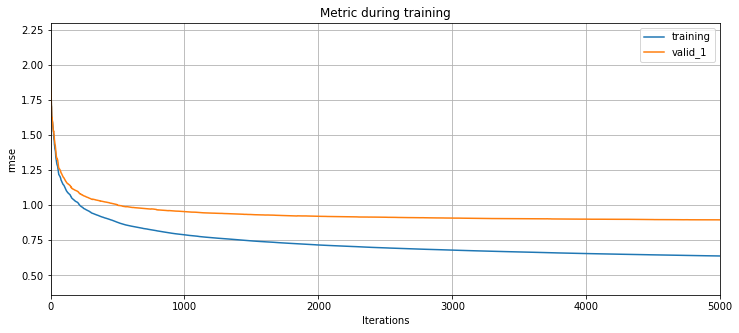

In [48]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

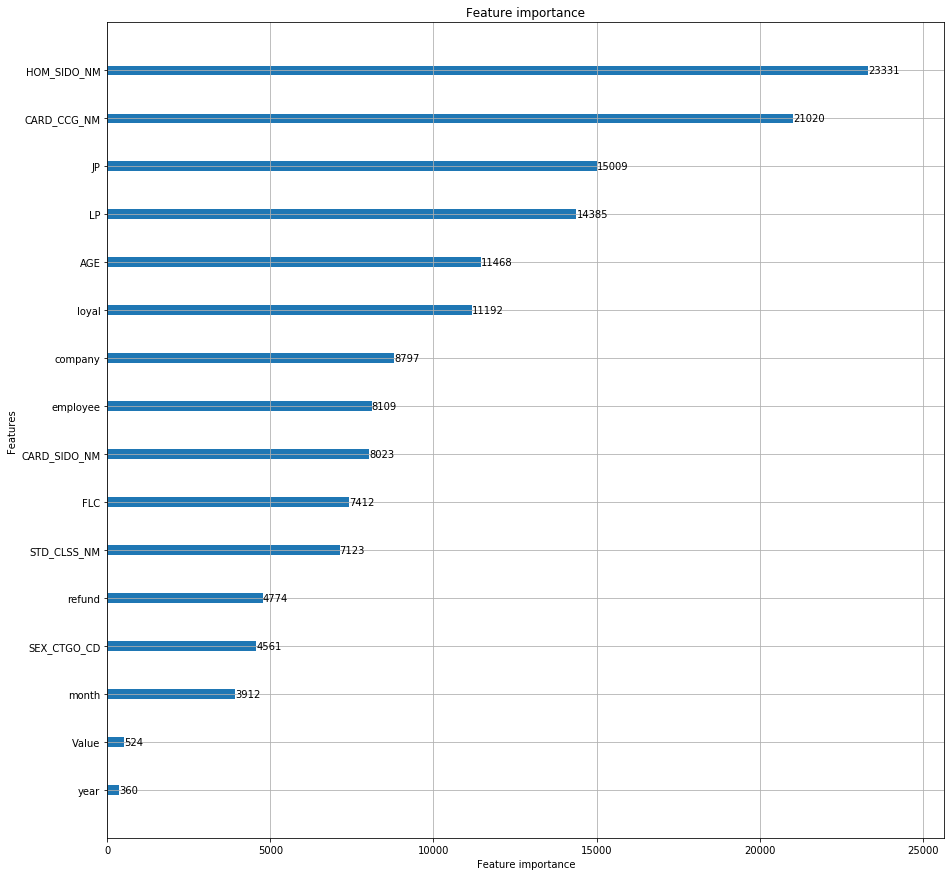

In [49]:
lgb.plot_importance(model, figsize=(15,15))

In [50]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [51]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [52]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,8.326268e+07
1,202004,강원,골프장 운영업,5.206867e+09
2,202004,강원,과실 및 채소 소매업,1.335776e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.371622e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [53]:
submission.to_csv('submission/submission lgbm 0728 valid Jan trade.csv', encoding='utf-8-sig')